In [22]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [23]:
%cd /gdrive/My Drive/ANN2

/gdrive/My Drive/ANN2


In [24]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [25]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [26]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [27]:
label_mapping =  {'Wish':0,        #0
          'Another':1,      #1
          'Comfortably':2,  #2
          'Money':3,        #3
          'Breathe':4,      #4
          'Time':5,         #5
          'Brain':6,        #6
          'Echoes':7,       #7
          'Wearing':8,      #8
          'Sorrow':9,       #9
          'Hey':10,          #10
          'Shine':11}      #11

In [28]:
dataset = np.load("Dataset/x_train.npy")
labels = np.load("Dataset/y_train.npy")
dataset.shape, labels.shape

((2429, 36, 6), (2429,))

In [29]:
#x_train, y_train = shuffle(dataset, labels, random_state=0)
indices = np.arange(dataset.shape[0])
np.random.shuffle(indices)

x_train = dataset[indices]
y_train = labels[indices]

x_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [30]:
y_train = tfk.utils.to_categorical(y_train)
x_train.shape, y_train.shape

((2429, 36, 6), (2429, 12))

In [31]:
#x_train = np.asarray([dataset[i, :, :] for i in range(int(dataset.shape[0] * 0.7))])
#x_val = np.asarray([dataset[i, :, :] for i in range(int(dataset.shape[0] * 0.7), int(len(dataset) * 0.9))])
#x_test = np.asarray([dataset[i, :, :] for i in range(int(dataset.shape[0] * 0.9), len(dataset))])
#x_train.shape, x_val.shape, x_test.shape

In [32]:
#y_train = np.asarray([labels[i, :] for i in range(int(labels.shape[0] * 0.7))])
#y_val = np.asarray([labels[i, :] for i in range(int(labels.shape[0] * 0.7), int(len(labels) * 0.9))])
#y_test = np.asarray([labels[i, :] for i in range(int(labels.shape[0] * 0.9), len(labels))])
#y_train.shape, y_val.shape, y_test.shape

In [33]:
#x_train

In [34]:
x_train_min = x_train.min(axis=(2), keepdims=True)
x_train_max = x_train.max(axis=(2), keepdims=True)
#(v - v_min)/(v_max - v_min)

x_train = (x_train - x_train_min)/(x_train_max - x_train_min)
#x_val = (x_val - x_train_min)/(x_train_max - x_train_min)
#x_test = (x_test - x_train_min)/(x_train_max - x_train_min)
#x_train
#x_train_min, x_train_max

In [35]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 16
epochs = 200

In [36]:
def build_1DCNN_classifier(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    conv1 = tfkl.Conv1D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling1D(pool_size=2)(conv1)
    conv2 = tfkl.Conv1D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling1D(pool_size=2)(conv2)
    conv3 = tfkl.Conv1D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    gap = tfkl.GlobalAveragePooling1D()(conv3)
    dropout = tfkl.Dropout(0.2, seed=seed)(gap)

    # Classifier
    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.2, seed=seed)(classifier_layer)
    classifier_layer2 = tfkl.Dense(units=128, name='Classifier2', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.2, seed=seed)(classifier_layer2)
    output_layer = tfkl.Dense(units=12, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

    # Return the model
    return model

In [37]:
model = build_1DCNN_classifier(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 32)            608       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 18, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 9, 64)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 9, 128)            24704 

In [38]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    #validation_data = (x_val, y_val),
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)
        #tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
122/122 [==============================] - 2s 9ms/step - loss: 2.4788 - accuracy: 0.1822 - val_loss: 2.0715 - val_accuracy: 0.3272
Epoch 2/200
122/122 [==============================] - 1s 7ms/step - loss: 2.2018 - accuracy: 0.2568 - val_loss: 2.0565 - val_accuracy: 0.3272
Epoch 3/200
122/122 [==============================] - 1s 7ms/step - loss: 2.1501 - accuracy: 0.2923 - val_loss: 2.0433 - val_accuracy: 0.3272
Epoch 4/200
122/122 [==============================] - 1s 7ms/step - loss: 2.1200 - accuracy: 0.2985 - val_loss: 2.0216 - val_accuracy: 0.3292
Epoch 5/200
122/122 [==============================] - 1s 7ms/step - loss: 2.0958 - accuracy: 0.3078 - val_loss: 2.0169 - val_accuracy: 0.3374
Epoch 6/200
122/122 [==============================] - 1s 7ms/step - loss: 2.0908 - accuracy: 0.3134 - val_loss: 1.9853 - val_accuracy: 0.3416
Epoch 7/200
122/122 [==============================] - 1s 6ms/step - loss: 2.0537 - accuracy: 0.3278 - val_loss: 1.9570 - val_accuracy: 0.3724

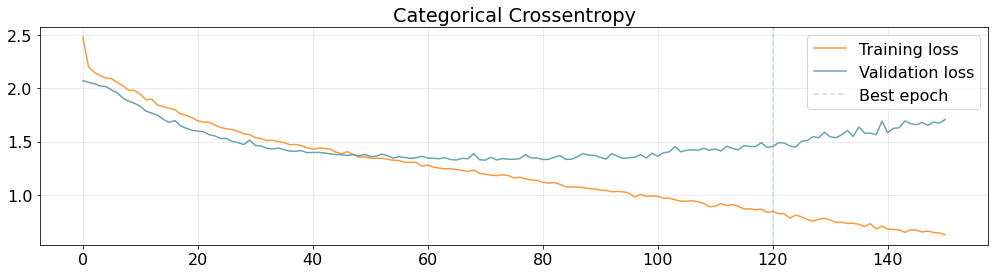

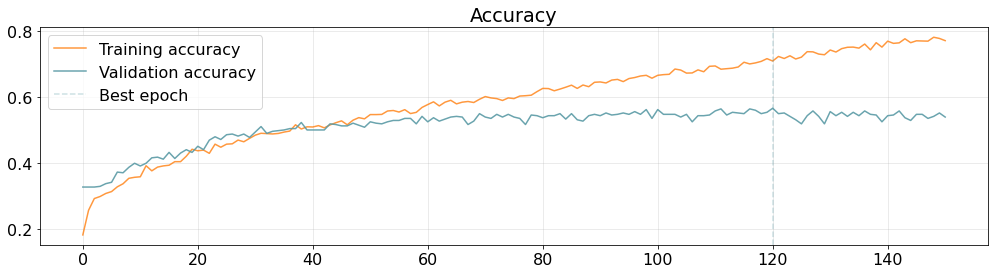

In [39]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plt.figure(figsize=(18,3))
#plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
#plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
#plt.legend()
#plt.grid(alpha=.3)
#plt.show()

In [40]:
model.save("Models/Model2")

In [41]:
#predictions = model.predict(x_test)
#predictions.shape

In [42]:
# Compute the confusion matrix
#cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
#accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
#precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#print('Accuracy:',accuracy.round(4))
#print('Precision:',precision.round(4))
#print('Recall:',recall.round(4))
#print('F1:',f1.round(4))

# Plot the confusion matrix
#plt.figure(figsize=(10,8))
#sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
#plt.xlabel('True labels')
#plt.ylabel('Predicted labels')
#plt.show()